In [1]:
import json
from data.preprocess import DataProcessor
import os
from data.custom_dataset import CustomDataset
from data.utils import get_dataset, get_tokenizer, get_dataloader
from model.model import Model
import torch
import pandas as pd
import numpy as np
import torch.optim as optim
import ast
import os
import itertools
import torch.utils.checkpoint
from torch.cuda.amp import GradScaler, autocast
from training.trainer import Trainer
import argparse


/vol/bitbucket/mh1022/dl_cw_pyenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch.multiprocessing
torch.multiprocessing.set_sharing_strategy('file_system')
# parser = argparse.ArgumentParser(description="Train model",
#                                 formatter_class=argparse.ArgumentDefaultsHelpFormatter)
# parser.add_argument("-n", "--num_chunks", type=int, help="number of chunks")
# parser.add_argument("-r", "--run_name", type=str, help="run name")
# parser.add_argument("-m", "--max_epochs", type=int, help="number of max epochs")
# parser.add_argument("-l", "--num_heads_labattn", type=int, help="number of heads for lab attention")
# parser.add_argument("-p", "--patience_threshold", type=int, help="patience threshold")

# args = parser.parse_args()
# args_config = vars(args)

# # device
USE_GPU = True
dtype = torch.float32
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
cpu = torch.device('cpu')
print(device)

### for debugging use cpu
#device = cpu

config = {
#    "run_name": "Run_test_TLWAN"
    "run_name": "visualization"
    ,"project_path": '/vol/bitbucket/mh1022/temporal-modelling-icd'
    ,"base_checkpoint": os.path.join("", "RoBERTa-base-PM-M3-Voc-hf")
    ,"num_attention_heads": 1
    ,"num_layers": 1
    ,"lr": 5e-5
    ,"max_chunks": 16
    ,"grad_accumulation": 16
    ,"use_positional_embeddings": True
    ,"use_reverse_positional_embeddings": True
    ,"priority_mode": "None"
    ,"priority_idxs": [1]
    ,"use_document_embeddings": True
    ,"use_reverse_document_embeddings": True
    ,"use_category_embeddings": True
    ,"num_labels": 50
    ,"use_all_tokens": True
    ,"num_heads_labattn": 1
    ,"final_aggregation": "cls"
    ,"only_discharge_summary": False
    ,"patience_threshold": 3
    ,"max_epochs": 20
    ,"save_model": False
    ,"load_from_checkpoint": False
    ,"checkpoint_name": "Run_all_notes_last_second_transf"
}

with open(os.path.join("", f"results/config_{config['run_name']}.json"), "w") as f:
    json.dump(config, f)

# process and aggregate raw data
dp = DataProcessor(dataset_path="dataset", config=config)
notes_agg_df = dp.aggregate_data()

# get tokenizer
tokenizer = get_tokenizer(config["base_checkpoint"])

# Get training / validation / test
dataset_config = {
    "max_chunks" : config["max_chunks"],
    "priority_mode" : config["priority_mode"],
    "priority_idxs" : config["priority_idxs"]
}
training_set = get_dataset(notes_agg_df, "TRAIN", tokenizer = tokenizer, **dataset_config)
training_generator = get_dataloader(training_set)

validation_set =  get_dataset(notes_agg_df, "VALIDATION", tokenizer = tokenizer, **dataset_config)
validation_generator = get_dataloader(validation_set)

test_set = get_dataset(notes_agg_df, "TEST", tokenizer = tokenizer, **dataset_config)
test_generator = get_dataloader(test_set)


cuda:0


/vol/bitbucket/mh1022/temporal-modelling-icd/data/preprocess.py:16: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  self.notes_df = pd.read_csv(os.path.join(dataset_path, "NOTEEVENTS.csv"))


{'Nursing/other': 0, 'Radiology': 1, 'Nursing': 2, 'Physician ': 3, 'ECG': 4, 'Discharge summary': 5, 'Respiratory ': 6, 'Echo': 7, 'Nutrition': 8, 'General': 9, 'Rehab Services': 10, 'Social Work': 11, 'Case Management ': 12, 'Consult': 13, 'Pharmacy': 14}


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 1729/1729 [02:16<00:00, 12.62it/s]


In [24]:
def get_cutoffs(hours_elapsed, category_ids):
    cutoffs = {'2d': -1, '5d': -1, '13d': -1, 'noDS': -1, 'all': -1}
    for i, (hour, cat) in enumerate(zip(hours_elapsed, category_ids)):
        if cat != 5:
            if hour < 2*24:
                cutoffs['2d'] = i
            if hour < 5*24:
                cutoffs['5d'] = i
            if hour < 13*24:
                cutoffs['13d'] = i
            cutoffs['noDS'] = i
        cutoffs['all'] = i
    return cutoffs

In [25]:
from tqdm import tqdm
notes_length = {'2d': [], '5d': [], '13d': [], 'noDS': [], 'all': []}
num_samples = {'2d': [], '5d': [], '13d': [], 'noDS': [], 'all': []}

for i in range(len(training_set)):
    sample = training_set[i]
    cutoffs = get_cutoffs(sample['hours_elapsed'], sample['category_ids'])
    for time_range in cutoffs.keys():
        if cutoffs != -1:
            notes_length[time_range].append(cutoffs[time_range])
            num_samples[time_range].append(1)


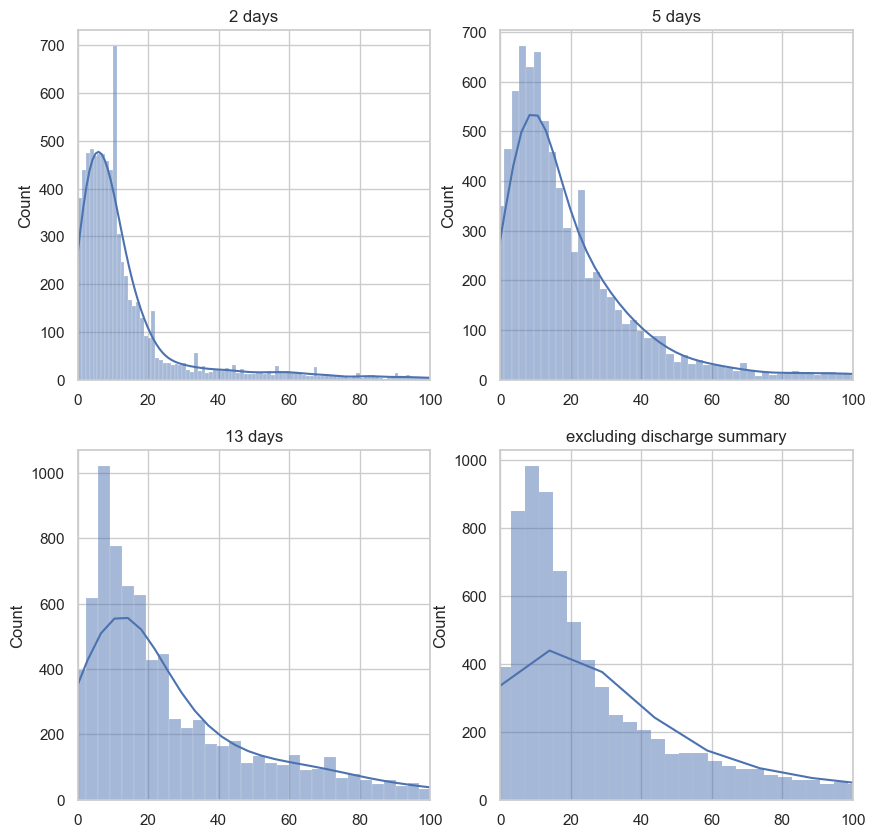

In [26]:
# plot the distribution of notes length for each time range
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
sns.histplot(notes_length['2d'], ax=axs[0, 0], kde=True)
axs[0, 0].set_title('2 days')
# limit x-axis range from 0 to 1000
axs[0, 0].set_xlim([0, 100])
sns.histplot(notes_length['5d'], ax=axs[0, 1], kde=True)
axs[0, 1].set_title('5 days')
axs[0, 1].set_xlim([0, 100])

sns.histplot(notes_length['13d'], ax=axs[1, 0], kde=True)
axs[1, 0].set_title('13 days')
axs[1, 0].set_xlim([0, 100])

sns.histplot(notes_length['noDS'], ax=axs[1, 1], kde=True)
axs[1, 1].set_title('excluding discharge summary')
axs[1, 1].set_xlim([0, 100])

plt.show()


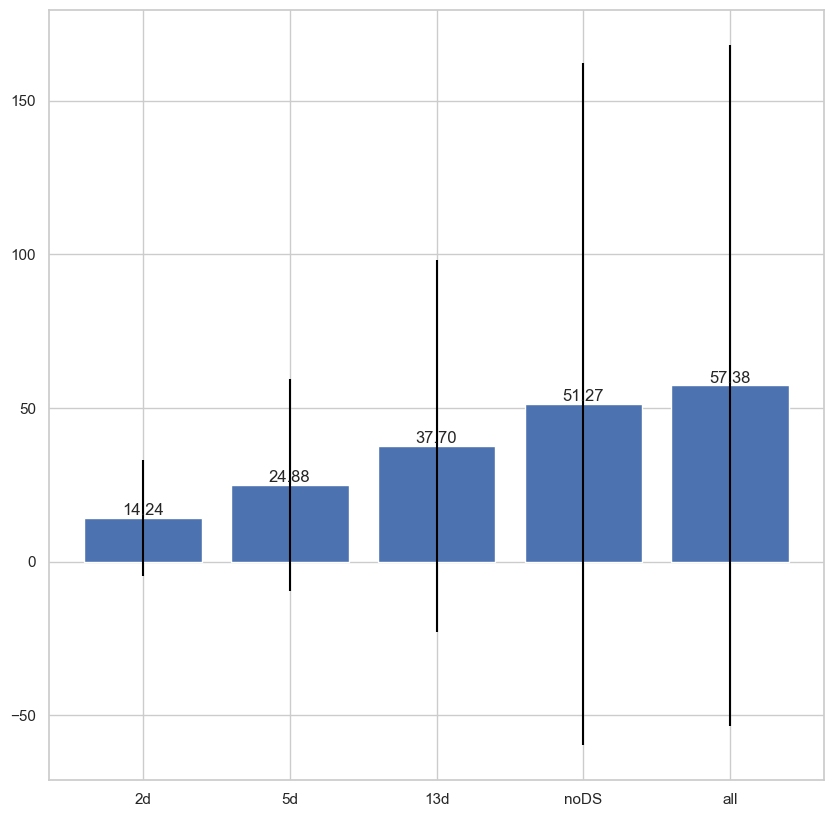

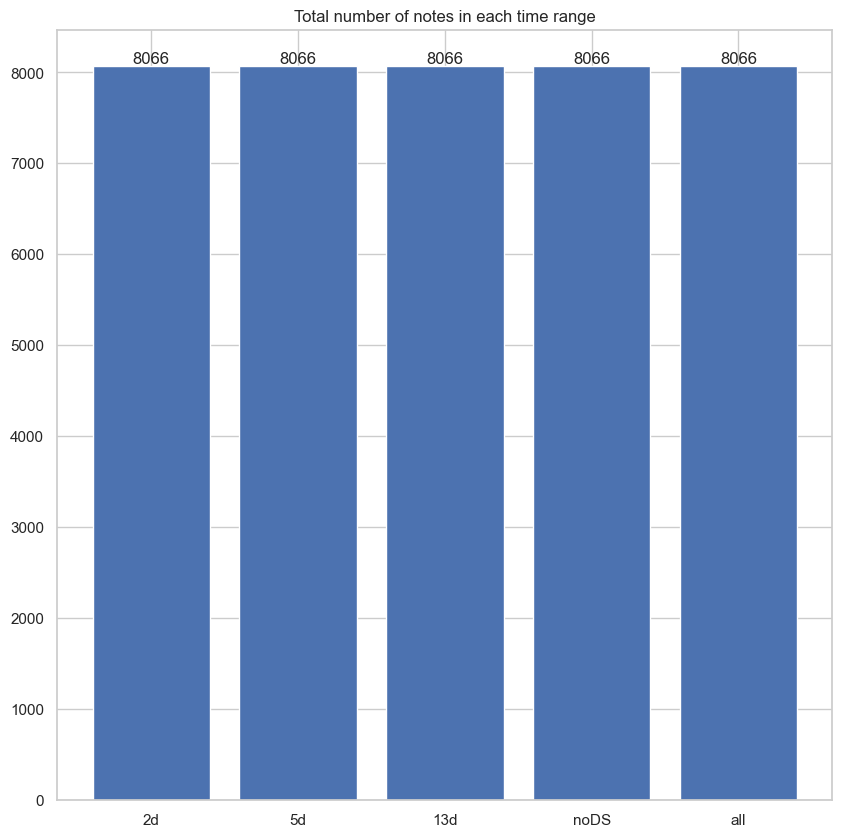

In [37]:
# print bar plot with the average number of notes and number of samples in each time range
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 10))
plt.bar(notes_length.keys(), [np.mean(notes_length[key]) for key in notes_length.keys()])
# show the standard deviation on the bar plot
# show the average number of notes in each time range on top of the bar plot as a number
for i, time_range in enumerate(notes_length.keys()):
    plt.text(i, np.mean(notes_length[time_range]), f"{np.mean(notes_length[time_range]):.2f}", ha='center', va='bottom')
plt.errorbar(notes_length.keys(), [np.mean(notes_length[key]) for key in notes_length.keys()], yerr=[np.std(notes_length[key]) for key in notes_length.keys()], fmt='none', c='black')
# add another bar plot with the number of samples
# the bar plot needs to be separated from the previous one
# otherwise the y-axis will be shared and the number of samples will be too small to be seen
plt.figure(figsize=(10, 10))

plt.bar(notes_length.keys(), [np.sum(num_samples[key]) for key in notes_length.keys()])
# show number of samples on top of the bar plot as a number
for i, time_range in enumerate(notes_length.keys()):
    plt.text(i, np.sum(num_samples[time_range]), f"{np.sum(num_samples[time_range]):.0f}", ha='center', va='bottom')
plt.title('Total number of notes in each time range')
plt.show()


Average total duration: 11.35 days
Std total duration: 12.98 days
Min total duration: 0.00 days
Max total duration: 192.00 days


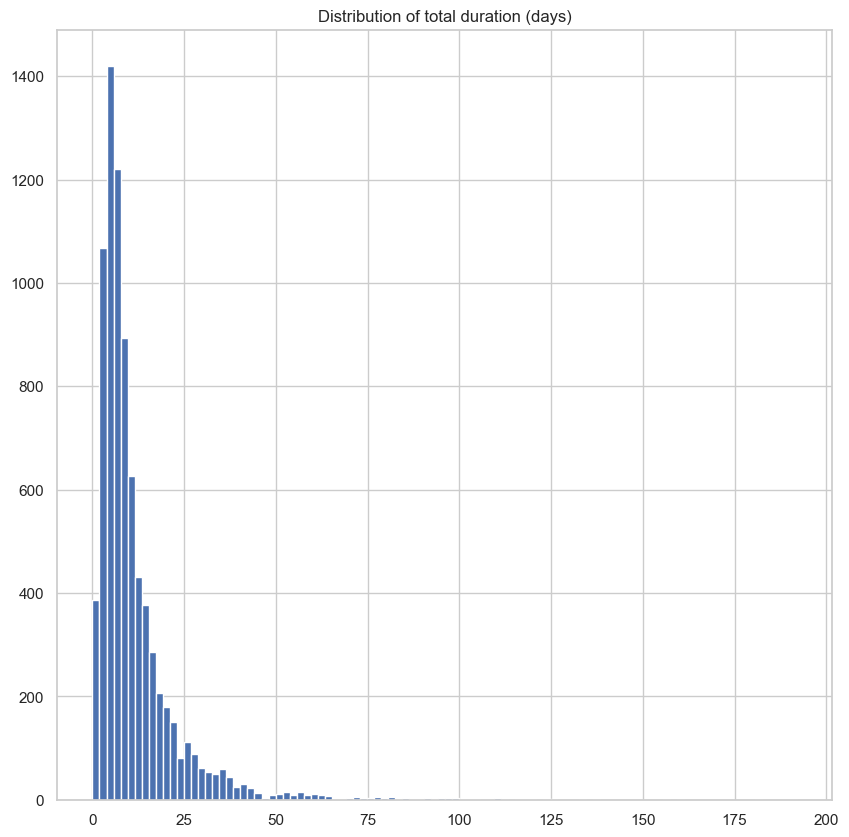

In [41]:
# show the shortest and longest stay
# by looking at hours_elapsed[-1]
# and the number of notes in each time range
total_duration = []
for i in range(len(training_set)):
    sample = training_set[i]
    total_duration.append(sample['hours_elapsed'][-1])
# show the average, std, min, max of the total duration
# in days
print(f"Average total duration: {np.mean(total_duration)/24:.2f} days")
print(f"Std total duration: {np.std(total_duration)/24:.2f} days")
print(f"Min total duration: {np.min(total_duration)/24:.2f} days")
print(f"Max total duration: {np.max(total_duration)/24:.2f} days")

# plot the distribution of total duration
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.hist([d/24 for d in total_duration], bins=100)
plt.title('Distribution of total duration (days)')
plt.show()


In [ ]:
from tqdm import tqdm
notes_length = {'2d': [], '5d': [], '13d': [], 'noDS': [], 'all': []}
num_samples = {'2d': [], '5d': [], '13d': [], 'noDS': [], 'all': []}

num_chunks = 
for i in tqdm(range(len(training_set))):
    sample = training_set[i]
    hours_elapsed = sample["hours_elapsed"]
    seq_ids = sample["seq_ids"]
    for time_range in sample["cutoffs"].keys():
        if sample["cutoffs"][time_range] != -1:
            notes_length[time_range].append(sample['cutoffs'][time_range])
            num_samples[time_range].append(1)
